In [1]:
import pandas as pd

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [3]:
df = pd.read_csv('/content/drive/My Drive/standard_df_MI.csv')

In [4]:
df.set_index('date', inplace=True)

In [6]:
df

,Open,High,Low,Open_ewma_5,Open_ewma_21,Open_ewma_63,Open_ewma_126,Open_ewma_252,High_ewma_5,High_ewma_21,High_ewma_63,High_ewma_126,High_ewma_252,Low_ewma_5,Low_ewma_21,Low_ewma_63,Low_ewma_126,Low_ewma_252,EURUSD_rolling_stdev_21,AUDUSD_rolling_stdev_5,AUDUSD_rolling_stdev_21,AUDUSD_rolling_min_21,AUDUSD_rolling_max_21,NZDUSD_rolling_stdev_21,USDNOK_rolling_stdev_21,VIX_ewma_5,VIX_ewma_21,VIX_ewma_63,VIX_ewma_126,VIX_ewma_252,SP500_rolling_stdev_5,SP500_rolling_min_5,SP500_rolling_max_5,SP500_rel_lvl_max_5,SP500_rolling_stdev_21,SP500_rolling_min_21,SP500_rolling_max_21,SP500_rel_lvl_max_21,XLE_rolling_stdev_5,XLE_rolling_min_5,...,XLU_rolling_stdev_21,XLU_rolling_min_21,XLU_rolling_max_21,XLI_rolling_stdev_5,XLI_rolling_min_5,XLI_rel_lvl_max_5,XLI_rolling_stdev_21,XLI_rolling_min_21,XLI_rolling_max_21,XLI_rel_lvl_max_21,XLK_rolling_stdev_5,XLK_rolling_min_5,XLK_rolling_stdev_21,XLK_rolling_min_21,XLK_rolling_max_21,XLK_rel_lvl_max_21,XLV_rolling_stdev_5,XLV_rolling_min_5,XLV_rolling_stdev_21,XLV_rolling_min_21,XLV_rolling_max_21,XLV_rel_lvl_max_21,XLY_rolling_stdev_5,XLY_rolling_min_5,XLY_rel_lvl_max_5,XLY_rolling_stdev_21,XLY_rolling_min_21,XLY_rolling_max_21,XLY_rel_lvl_max_21,XLP_rolling_stdev_5,XLP_rolling_min_5,XLP_rolling_stdev_21,XLP_rolling_min_21,XLP_rolling_max_21,XLB_rolling_stdev_5,XLB_rolling_min_5,XLB_rolling_stdev_21,XLB_rolling_min_21,XLB_rolling_max_21,XLB_rel_lvl_max_21
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-02-03,22.719999,23.730000,21.930000,23.475805,23.221349,23.240876,23.270829,23.290072,24.647612,24.271529,24.215135,24.228036,24.239472,22.670419,22.422952,22.402022,22.416982,22.428111,0.006225,0.024011,0.012228,-0.043511,0.018675,0.011196,0.005662,23.159444,23.136455,23.120083,23.134011,23.144476,0.019704,-0.027457,0.025218,1.000000,0.013902,-0.027634,0.027090,0.972576,0.014727,-0.011966,...,0.016098,-0.023295,0.046126,0.012825,-0.026479,0.993103,0.014605,-0.028682,0.038101,0.919149,0.027875,-0.035714,0.023386,-0.035714,0.037990,0.997669,0.017259,-0.020243,0.027987,-0.029844,0.102255,0.960038,0.027307,-0.039466,0.997228,0.019607,-0.039466,0.047109,0.919734,0.012970,-0.013560,0.019958,-0.028801,0.063395,0.015029,-0.017027,0.017507,-0.026428,0.041312,0.853811
2000-02-04,20.770000,21.770000,20.690001,22.573816,22.973318,23.096077,23.146512,23.175208,23.688351,24.018420,24.071844,24.105845,24.126914,22.010241,22.247609,22.301694,22.331133,22.348889,0.006564,0.012661,0.012423,-0.043511,0.018675,0.011238,0.006262,22.619597,22.974923,23.027486,23.054772,23.071344,0.010512,-0.000421,0.025218,0.999579,0.013903,-0.027634,0.027090,0.972167,0.019573,-0.028835,...,0.015171,-0.023295,0.046126,0.005233,-0.006897,0.997127,0.014642,-0.028682,0.038101,0.922872,0.011003,0.007264,0.023200,-0.035714,0.037990,1.000000,0.010905,-0.004648,0.027844,-0.029844,0.102255,0.963368,0.016729,-0.006652,0.995565,0.019455,-0.039466,0.047109,0.918200,0.012543,-0.013560,0.019614,-0.028801,0.063395,0.012993,-0.017027,0.014102,-0.026428,0.025671,0.852673
2000-02-07,22.969999,23.270000,22.790001,22.705882,22.972985,23.088885,23.138025,23.166194,23.548895,23.943464,24.026105,24.065660,24.089275,22.270171,22.301931,22.329548,22.353195,22.368264,0.006649,0.008829,0.012481,-0.043511,0.018675,0.011242,0.006298,22.676401,22.956403,23.013940,23.042042,23.058986,0.006111,-0.000421,0.011248,0.999488,0.013904,-0.027634,0.027090,0.972078,0.015945,-0.028835,...,0.015179,-0.023295,0.046126,0.008405,-0.017292,0.982708,0.014631,-0.028682,0.038101,0.906915,0.008731,0.007264,0.021791,-0.035714,0.037990,1.000000,0.015033,-0.016297,0.028193,-0.029844,0.102255,0.947669,0.021195,-0.021158,0.974501,0.019701,-0.039466,0.047109,0.898773,0.006710,-0.013560,0.019172,-0.028801,0.063395,0.015565,-0.019346,0.012312,-0.026428,0.018084,0.836653
2000-02-08,21.680000,22.080000,21.170000,22.363913,22.844675,23.010540,23.070122,23.103183,23.059250,23.758542,23.917886,23.973184,24.004086,21.903438,22.189604,22.265068,22.298

In [5]:
timeseries = np.array(df)

In [6]:
timeseries.shape

(4962, 91)

In [7]:
n_features = timeseries.shape[1]

In [8]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [24]:
timesteps = 1
X, y = temporalize(timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)

In [25]:
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

In [26]:
X

array([[[ 2.29699990e+01,  2.32700000e+01,  2.27900010e+01, ...,
         -2.64283543e-02,  1.80843879e-02,  8.36653324e-01]],

       [[ 2.16800000e+01,  2.20800000e+01,  2.11700000e+01, ...,
         -2.64283543e-02,  1.80843879e-02,  8.37235658e-01]],

       [[ 2.15400010e+01,  2.29000000e+01,  2.12900010e+01, ...,
         -2.64283543e-02,  1.80843879e-02,  8.30635808e-01]],

       ...,

       [[ 4.20200000e+01,  4.94800000e+01,  3.93699990e+01, ...,
         -4.68526016e-02,  2.09960257e-02,  8.64403999e-01]],

       [[ 3.85400010e+01,  4.04100000e+01,  3.15000000e+01, ...,
         -4.68526016e-02,  4.28679615e-02,  9.01459236e-01]],

       [[ 3.36500020e+01,  4.10600010e+01,  2.49300000e+01, ...,
         -4.68526016e-02,  4.28679615e-02,  8.93589096e-01]]])

In [12]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            112640    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 91)             11739     
Total params: 305,627
Trainable params: 305,627
Non-trainable params: 0
________________________________________________

In [14]:
model.fit(X, X, epochs=50, batch_size=10)

Epoch 1/50
4960/4960 [==============================] - 4s 827us/step - loss: 0.2014
Epoch 2/50
4960/4960 [==============================] - 4s 778us/step - loss: 0.1792
Epoch 3/50
4960/4960 [==============================] - 4s 807us/step - loss: 0.1136
Epoch 4/50
4960/4960 [==============================] - 4s 789us/step - loss: 0.0724
Epoch 5/50
4960/4960 [==============================] - 4s 818us/step - loss: 0.0695
Epoch 6/50
4960/4960 [==============================] - 4s 818us/step - loss: 0.0625
Epoch 7/50
4960/4960 [==============================] - 4s 826us/step - loss: 0.0679
Epoch 8/50
4960/4960 [==============================] - 4s 893us/step - loss: 0.0588
Epoch 9/50
4960/4960 [==============================] - 4s 905us/step - loss: 0.0642
Epoch 10/50
4960/4960 [==============================] - 4s 878us/step - loss: 0.0499
Epoch 11/50
4960/4960 [==============================] - 4s 824us/step - loss: 0.0426
Epoch 12/50
4960/4960 [==============================] - 4s 839

In [15]:
yhat = model.predict(X)

In [105]:
model.save('autoencoder.h5')

In [28]:
new_df = df[2:]

In [33]:
yhat = yhat.reshape(-1, n_features)

In [34]:
yhat.shape

(4960, 91)

In [41]:
yhat_df = pd.DataFrame(yhat, columns=new_df.columns )
yhat_df['date'] = new_df.index
yhat_df.set_index('date', inplace=True)

In [42]:
yhat_df.shape

(4960, 91)

In [104]:
yhat_df.to_csv('yhat_df.csv')

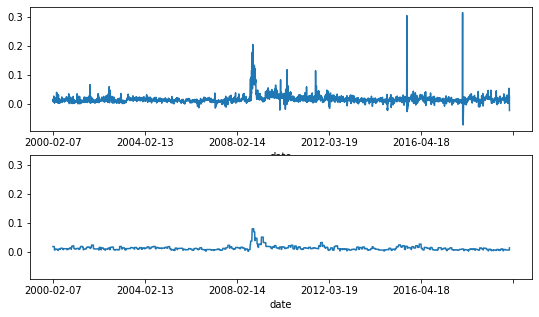

In [108]:

plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['AUDUSD_rolling_max_21']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['AUDUSD_rolling_max_21']
p2.plot()




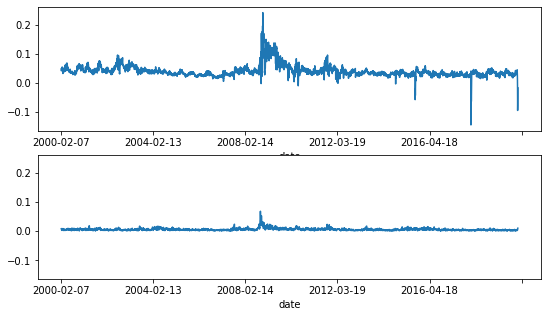

In [109]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['AUDUSD_rolling_stdev_5']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['AUDUSD_rolling_stdev_5']
p2.plot()

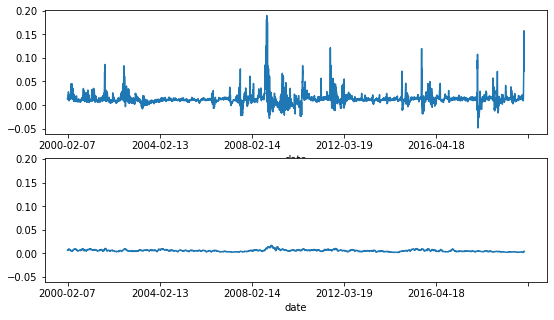

In [110]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['EURUSD_rolling_stdev_21']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['EURUSD_rolling_stdev_21']
p2.plot()

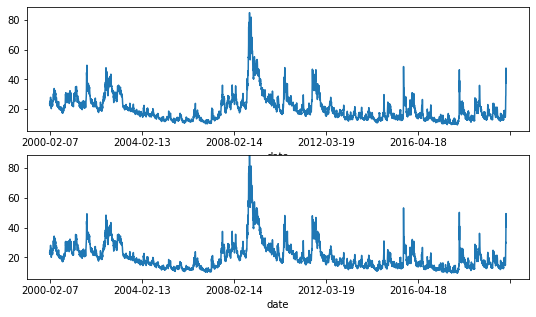

In [111]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['High']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['High']
p2.plot()

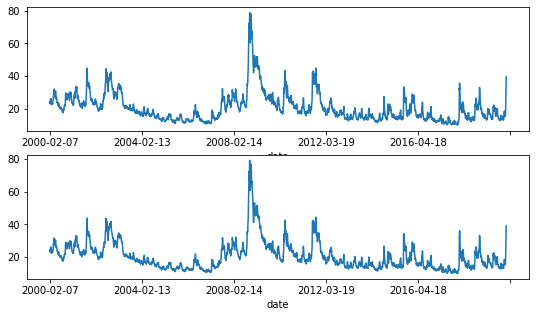

In [112]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['High_ewma_5']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['High_ewma_5']
p2.plot()

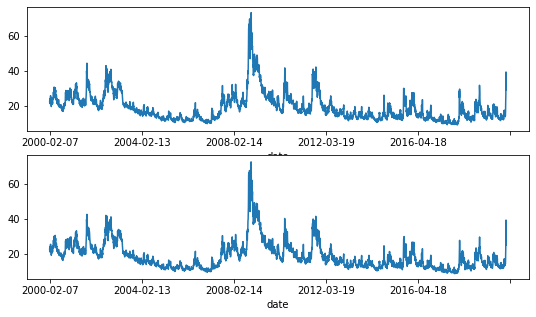

In [113]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['Low']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['Low']
p2.plot()

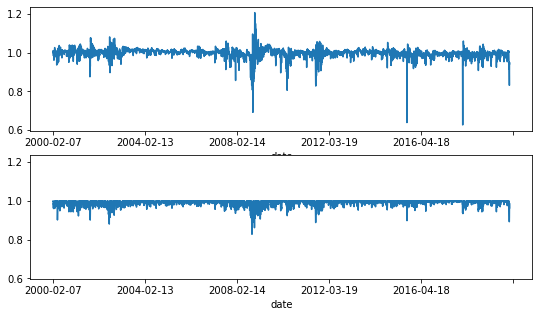

In [114]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['SP500_rel_lvl_max_5']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['SP500_rel_lvl_max_5']
p2.plot()

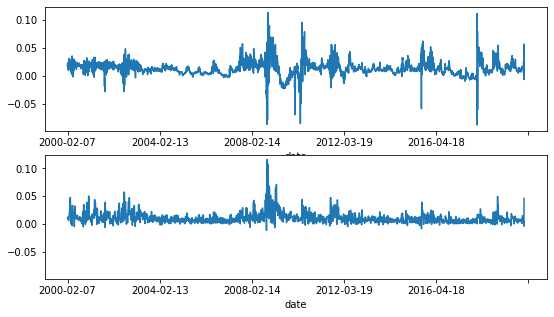

In [115]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['SP500_rolling_max_5']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['SP500_rolling_max_5']
p2.plot()

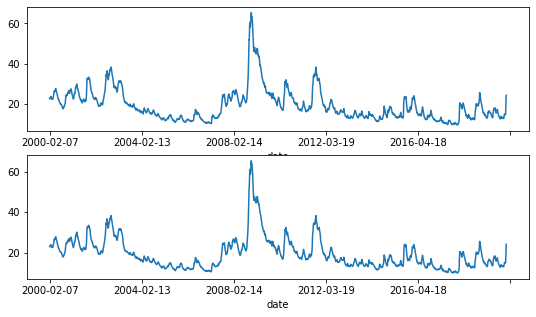

In [116]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['VIX_ewma_21']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['VIX_ewma_21']
p2.plot()

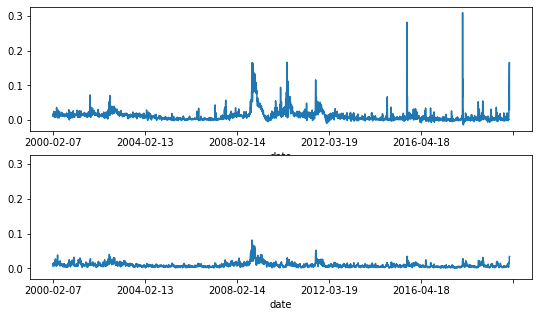

In [117]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['SP500_rolling_stdev_5']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['SP500_rolling_stdev_5']
p2.plot()

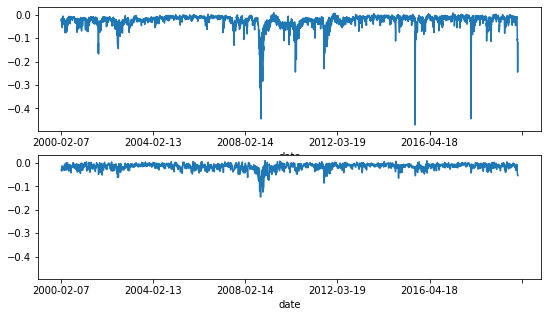

In [118]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['XLE_rolling_min_5']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['XLE_rolling_min_5']
p2.plot()

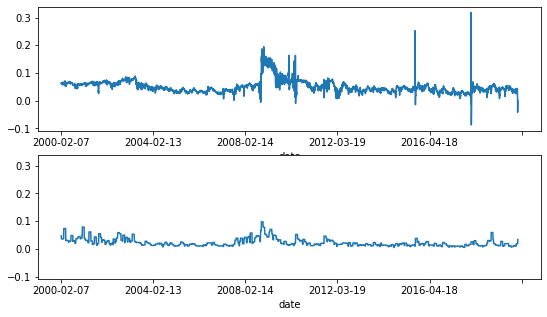

In [119]:
plt.figure(figsize=(9,5))

plt.subplot(211)
p1 = yhat_df['XLY_rolling_max_21']
p1.plot()
ax = plt.axis()

plt.subplot(212)
plt.axis([ax[0], ax[1], ax[2], ax[3]])
p2 = new_df['XLY_rolling_max_21']
p2.plot()

In [46]:
yhat_df.to_csv('df_MI_autoencoder.csv')

In [55]:
y_true = pd.read_csv('/content/drive/My Drive/y_true.csv')

In [59]:
y_true.shape

(4960, 1)

In [57]:
y_true.set_index('date', inplace=True)

In [58]:
y_true = y_true[2:]

In [61]:
dataset = np.concatenate((yhat_df, y_true),axis=1) 

In [64]:
num_train = int(0.9*len(dataset))

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Split
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
#Feature selection / dimension reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV,SelectPercentile,f_regression
#Performance evaluation
from sklearn import metrics

In [68]:
scaler = StandardScaler()
#Fit scaler using the training data
scaler.fit(dataset[:num_train])
data_scaled = scaler.transform(dataset)

In [69]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [70]:
past_history = 1
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(data_scaled, data_scaled[:, -1], 0,
                                                   num_train, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(data_scaled, data_scaled[:, -1],
                                               num_train, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [71]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional,Activation

In [72]:
#BATCH_SIZE = 256
BATCH_SIZE = 1
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [73]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add((tf.keras.layers.LSTM(256,input_shape=x_train_single.shape[-2:],return_sequences=True)))
#single_step_model.add(tf.keras.layers.LSTM(64, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.Dropout(0.99)) # Add dropout with a probability of 0.5
single_step_model.add((tf.keras.layers.LSTM(128, activation='relu')))
#single_step_model.add(tf.keras.layers.LSTM(, activation='relu'))
#single_step_model.add(tf.keras.layers.Dropout(0.99)) # Add dropout with a probability of 0.5
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(loss='mae', optimizer='nadam')

In [74]:
EPOCHS = 100
EVALUATION_INTERVAL = 200
single_step_history =single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/100
200/200 [==============================] - 3s 15ms/step - loss: 0.2754 - val_loss: 0.2434
Epoch 2/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1935 - val_loss: 0.2617
Epoch 3/100
200/200 [==============================] - 3s 13ms/step - loss: 0.2248 - val_loss: 0.1764
Epoch 4/100
200/200 [==============================] - 2s 12ms/step - loss: 0.2029 - val_loss: 0.2521
Epoch 5/100
200/200 [==============================] - 2s 12ms/step - loss: 0.2363 - val_loss: 0.1740
Epoch 6/100
200/200 [==============================] - 3s 13ms/step - loss: 0.2100 - val_loss: 0.1781
Epoch 7/100
200/200 [==============================] - 2s 12ms/step - loss: 0.2163 - val_loss: 0.2037
Epoch 8/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1761 - val_loss: 0.1772
Epoch 9/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1971 - val_loss: 0.1707
Epoch 10/100
200/200 [==============================] - 3s 14ms/step - loss: 0.199

In [83]:
single_step_model.save('basicmodel_encoder.h5')

In [75]:
pred = single_step_model.predict(x_val_single)

In [76]:
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            357376    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 554,625
Trainable params: 554,625
Non-trainable params: 0
_________________________________________________________________


In [77]:
def get_mae(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))    

def get_mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

In [78]:
get_mae(pred,y_val_single)

0.4490226521787293

In [79]:
get_mse(pred,y_val_single)

0.38502239167171626

In [80]:
x_val_single.shape

(495, 1, 92)

In [81]:
df1 = y_true[-495:]

Text(0, 0.5, 'USD')

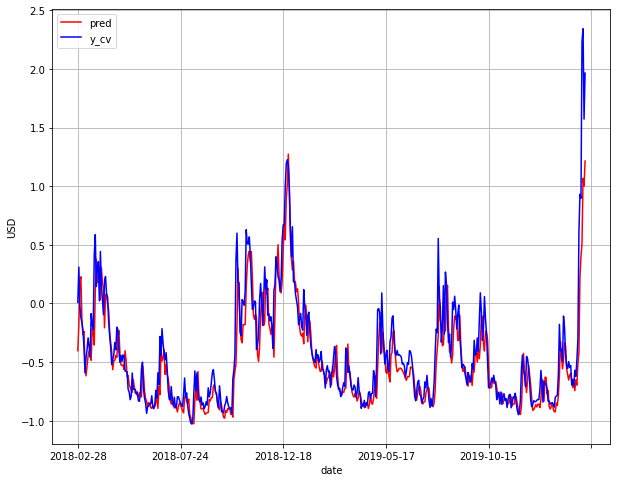

In [82]:
from pylab import rcParams
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'pred': pred.reshape(-1), 
                       'y_cv': y_val_single.reshape(-1),
                       'date': df1.index})
ax = est_df.plot(x='date', y='pred', style='r-', grid=True)
ax = est_df.plot(x='date', y='y_cv', style='b', grid=True, ax=ax)
ax.set_xlabel("date")
ax.set_ylabel("USD")